In [53]:
# enable autoreload
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss

# include project src in path
sys.path.append(os.path.abspath("src"))
from inference import run_inference, evaluate, evaluate_predictions, ensemble_inference
from monai.losses import DiceCELoss
from utils_visualization import visualize_slices
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = "results/exp24_nnunet/fold1/checkpoints/best.ckpt"
OUTPUT_DIR     = "results/inference"
BATCH_SIZE     = 3
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")  

In [55]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    weight=torch.tensor([0.4,1.7,1.5]).to(DEVICE),
    lambda_dice=0.5, lambda_ce=0.5
)

In [ ]:
# Single model
model, loader = run_inference(DATA_DIR, CHECKPOINT, OUTPUT_DIR, BATCH_SIZE, MODEL_TYPE, DEVICE)
metrics = evaluate(model, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Loading dataset:  55%|█████▌    | 11/20 [00:09<00:05,  1.56it/s]

In [ ]:
# Ensemble
CKPT_GLOB = "results/exp24_nnunet/fold*/checkpoints/best.ckpt"
OUT_ENS   = "results/inference/ensemble"

# run inference and grab model + loader
models, loader = ensemble_inference(DATA_DIR, OUT_ENS, CKPT_GLOB, MODEL_TYPE, BATCH_SIZE, DEVICE)
metrics_ens = evaluate(models, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics_ens.items():
    print(f"{key}: {value:.4f}")

Ensemble Inference: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Ensembled predictions saved to results/inference/ensemble


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.86it/s]

avg_loss: 0.3398
mean_dice: 0.6742
dice_class1: 0.8714
dice_class2: 0.4770
prec_class1: 0.6821
recall_class1: 0.6160
prec_class2: 0.6890
recall_class2: 0.5356


Label class distribution: (1738493, 22930, 8049)
Prediction class distribution: (1746818, 8851, 13803)


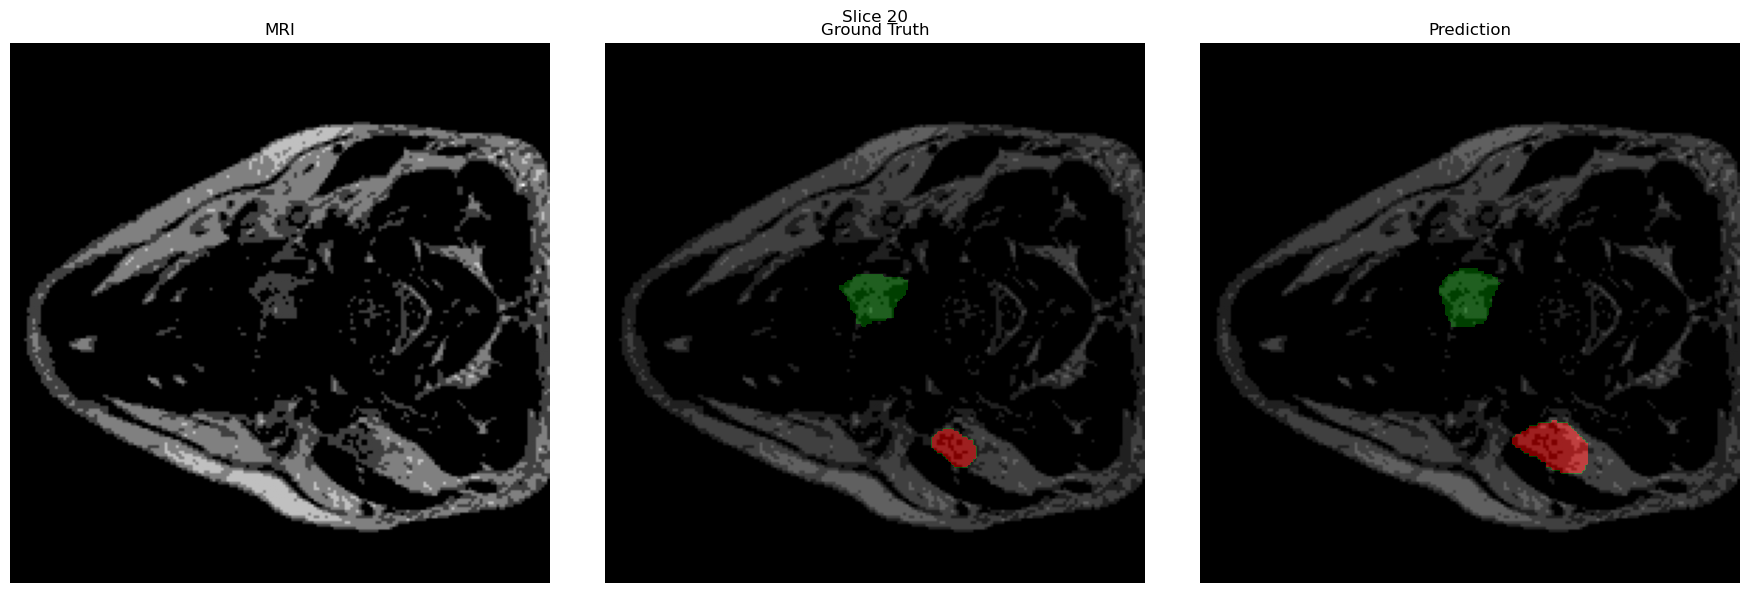

In [52]:
# Visualize
visualize_slices(f"{OUTPUT_DIR}/image_3.nii.gz",
                 f"{OUTPUT_DIR}/label_3.nii.gz",
                 f"{OUTPUT_DIR}/prediction_3.nii.gz", slice_idx=20)
